In [1]:
# add Cuba HypergeometricFunctions SpecialFunctions BenchmarkTools Interpolations Distributions KernelDensity DelimitedFiles StatsPlots NestedSamplers StatsBase Random MCMCChains AbstractMCMC BAT IntervalSets

In [2]:
Threads.nthreads()

32

In [111]:
model = "GWTC3_lognormal"
using Cuba
include("events.jl")
using Revise
using HypergeometricFunctions
using SpecialFunctions
using BenchmarkTools
using Interpolations
using Distributions
using KernelDensity
using DelimitedFiles
using StatsPlots
using NestedSamplers
using StatsBase: sample
using Random
# using MCMCChains
using FileIO
using BAT
using IntervalSets
using FileIO
using LaTeXStrings
using Roots
# using GWSC
using IntervalSets
using AbstractMCMC
# AbstractMCMC.setprogress!(false)
Random.seed!(8452);
using Trapz

In [4]:
using Cuba
using Interpolations
using DelimitedFiles

const yr = 365.25 * 24 * 3600 # seconds

abstract type Cosmology end
struct LCDM <: Cosmology
    h::Float64 # hubble const
    H0::Float64
    t0::Float64

    ΩM::Float64
    ΩΛ::Float64

    HH::Function
    ϕt::Function
    ϕr::Function
    ϕV::Function
    zt::Function
    tz::Function
    rz::Function
    DLz::Function # luminosity distance


    function LCDM(h, ΩM)
        ΩΛ = 1 - ΩM
        H0 = 100h / 3.08567758128e19 # https://www.unitconverters.net/length/megaparsec-to-kilometer.htm

        # eq.(A2) of arxiv:1712.01168
        HH(z) = sqrt(ΩΛ + ΩM * (1 + z)^3)

        # eq.(A5) of arxiv:1712.01168
        function ϕt0(z)
            int0(z) = 1 / HH(z) / (1 + z)
            int(y) = int0(z + y / (1 - y)) / (1 - y)^2
            # int(y) = 1/ (1-y) / (1+(1-y)*z) / HH(y/(1-y) + z)
            function integrand(x, f)
                f[1] = int(x[1])
            end
            result, err = cuhre(integrand, rtol=1e-3)
            result[1]
        end

        # eq.(A6) of arxiv:1712.01168
        function ϕr0(z)
            int0(z) = 1 / HH(z)
            int(y) = z * int0(z * y)
            # int(y) = z / HH(z*y)
            function integrand(x, f)
                f[1] = int(x[1])
            end
            result, err = cuhre(integrand, rtol=1e-3, minevals=10^5)
            result[1]
        end

        logzs = -10:0.01:2
        logϕts = log10.(ϕt0.(10 .^ logzs))
        logts = logϕts .- log10(H0) # eq.(A5) of arxiv:1712.01168
        logϕrs = log10.(ϕr0.(10 .^ logzs))

        writedlm("logzs_logϕts.txt", zip(logzs, logϕts))
        log_log_ϕt_inter = interpolate((logzs,), logϕts, Gridded(Linear()))
        ϕt(z) = 10^log_log_ϕt_inter(log10(z))
        tz(z) = ϕt(z) / H0 # eq.(A5) of arxiv:1712.01168

        log_log_zt_inter = interpolate((reverse(logts),), reverse(logzs), Gridded(Linear()))
        zt(t) = 10^log_log_zt_inter(log10(t))

        writedlm("logzs_logϕrs.txt", zip(logzs, logϕrs))
        log_log_ϕr_inter = interpolate((logzs,), logϕrs, Gridded(Linear()))
        ϕr(z) = 10^log_log_ϕr_inter(log10(z))
        rz(z) = ϕr(z) / H0 # eq.(A6) of arxiv:1712.01168
        DLz(z) = (1 + z) * ϕr(z) / H0

        # eq.(A7) of arxiv:1712.01168
        ϕV(z) = 4π * ϕr(z)^2 / (1 + z)^3 / HH(z)

        t0 = tz(1e-10)

        new(h, H0, t0, ΩM, ΩΛ, HH, ϕt, ϕr, ϕV, zt, tz, rz, DLz)
    end
end

In [5]:
h, ΩM = 0.7, 0.315
lcdm = LCDM(h, ΩM);

In [6]:
t0, tz, DLz = lcdm.t0, lcdm.tz, lcdm.DLz;

In [7]:
f = 0.0025693801260000975
mc = 8.896735628637506
σc = 0.9108320383237213
i = 10
j = 30
z = 1e-10

const m_min = 3
const m_max = 130
const δm = m_max - m_min

127

In [8]:
function mergerRateDensity1st(i, j, mc, σc, f)
    210084.52488130186 / (i^2 * j^2 * σc^2) * exp(-(743 * σc^4 + 1369 * log(i / mc)^2 + 1369 * log(j / mc)^2) / (2738 * σc^2)) * (i * j)^(3 / 37) * (i + j)^(36 / 37) * ((exp(σc^2 / 2) * f) / mc)^(53 / 37) * mc^(53 / 37)
end

function mergerRateDensity2nd1(i, j, mc, σc, f)
    tmp1 = 1009.5488113544313 * f^(69 / 37) * i^(6 / 37) * (i + j)^(72 / 37) / j^(68 / 37) / σc^3
    tmp2 = exp(-(-3318 * σc^4 + 1369 * log(j / mc)^2) / (2738 * σc^2))

    int0(e) = exp(-(1369 * log(e / mc)^2 + 1369 * log((-e + i) / mc)^2) / (2738 * σc^2)) / (e^2 * (-e + i)^2)

    vx = range(1e-1, i - 1e-1, length=20)
    M = [int0(e) for e = vx]
    # @show M
    result = trapz((vx), M)

    # int(e) = i * int0(i * e)
    # function integrand(x, f)
    #     f[1] = int(x[1])
    # end
    # result, err = cuhre(integrand, rtol=1e-1)
    tmp1 * tmp2 * result[1]
end

mergerRateDensity2nd(i, j, mc, σc, f) = 0.5 * (mergerRateDensity2nd1(i, j, mc, σc, f) + mergerRateDensity2nd1(j, i, mc, σc, f))

# function mergerRateDensity(i, j, mc, σc, f)
#     if i >= j
#         mergerRateDensity1st(i, j, mc, σc, f) + mergerRateDensity2nd(i, j, mc, σc, f)
#     else
#         mergerRateDensity(j, i, mc, σc, f)
#     end
# end

mergerRateDensity(i, j, mc, σc, f, z) = (tz(z) / t0)^(-34 / 37) * mergerRateDensity1st(i, j, mc, σc, f) + (tz(z) / t0)^(-31 / 37) * mergerRateDensity2nd(i, j, mc, σc, f)

function merger_rate(mc, σc, f, z)
    δm = m_max - m_min
    int(m1, m2) = δm^2 * mergerRateDensity(m_min + δm * m1, m_min + δm * m2, mc, σc, f, z)
    #     println("p1=$p10, p2=$p20, p3=$p30")
    function integrand(x, f)
        f[1] = int(x[1], x[2])
    end
    result, err = cuhre(integrand, rtol=1e-3)
    0.5 * result[1]
end

merger_rate (generic function with 1 method)

In [75]:
merger_rate.(16, 0.85, 2e-3, 1e-10)

26.149180588389

In [27]:
mergerRateDensity(i, j, mc, σc, 1e-1, z), mergerRateDensity(i, j, mc, σc, 1e-5, z), 

(4.3739217510996635, 6.586638484961205e-6)

In [10]:
@time mergerRateDensity(i, j, mc, σc, f, z)

  0.000021 seconds (17 allocations: 784 bytes)


0.01948733867435534

In [11]:
# mergerRateDensity1st(i, j, mc, σc, f)
# @time merger_rate(mc, σc, f, z)
# mergerRateDensity2nd(i, j, mc, σc, f)
# @time mergerRateDensity2nd(i, j, mc, σc, f)
# @time mergerRateDensity2nd1(i, j, mc, σc, f)

In [12]:
pdraws0 = readdlm("/home/czc/projects/working/LIGO_posterior/GWTC-3/GWTC-3_pdraw_m1_m2_z.txt");
n_draw0 = size(pdraws0)[1];
pdraws = pdraws0[rand(1:n_draw0, 1000), :]
n_draw = size(pdraws)[1];

In [84]:
# selection effect
function β_func(mc, σc, fpbh)
    β = 0.0
    for pdraw in eachrow(pdraws)
        m1, m2, z, pθ = pdraw
        β += mergerRateDensity(m1, m2, mc, σc, fpbh, z) / pθ
    end
    N_generated = 73280198 # number of generated injection for GWTC-3
    β / N_generated * n_draw0 / n_draw
end


β_func (generic function with 1 method)

In [85]:
β_func(mc, σc, 1e-1), β_func(mc, σc, 1e-3), β_func(mc, σc, 1e-4), β_func(mc, σc, 1e-5)

(14553.136692551065, 17.705759466270415, 0.6462050713771519, 0.02376615314276399)

In [87]:
@time β_func(mc, σc, f)

  0.003216 seconds (37.98 k allocations: 1.220 MiB)


69.08198837815044

In [88]:
function get_post(event)
    post_file = "/home/czc/projects/working/LIGO_posterior/src_masses_DL_z_posterior/GW$(event)_posterior.txt"
    post = readdlm(post_file)
end


function reduce_post(post, new_size)
    N = size(post)[1]
    if N < new_size
        return post
    end
    idx = rand(1:N, new_size)
    post[idx, :]
end

reduce_post (generic function with 1 method)

In [113]:
posts0 = [get_post(event) for event in GWTC3_events_BBH];


In [90]:
posts = [reduce_post(post, 100) for post in posts0];

In [91]:
post = posts[1];

In [92]:
# log(single_event_posterior * merger_rate_density)
function log_pR_func(mc, σc, fpbh, post)
    result = 0.0
    for p in eachrow(post)
        m1, m2, z, DL = p
        result += mergerRateDensity(m1, m2, mc, σc, fpbh, z) / DL^2
    end
    log(result / size(post)[1])
end

log_pR_func (generic function with 1 method)

In [93]:
log_pR_func(mc, σc, 1e-1, post), log_pR_func(mc, σc, 1e-5, post)

(0.3456890827112006, -13.26456230952383)

In [94]:
function logL(mc, σc, log_fpbh, posts)
    fpbh = 10.0^log_fpbh
    -β_func(mc, σc, fpbh) + sum(log_pR_func.(mc, σc, fpbh, posts))
end

logL (generic function with 1 method)

In [95]:
@time logL(17.068251251921872, 0.11702570160808631, -1, posts)

  0.054481 seconds (286.58 k allocations: 12.661 MiB, 57.09% compilation time)


-17289.654987636102

In [96]:
@time logL(17.068251251921872, 0.11702570160808631, -5, posts)

  0.023141 seconds (176.13 k allocations: 6.698 MiB)


-1920.7723867044215

In [97]:
log_fpbh = -2.871914894259725

-2.871914894259725

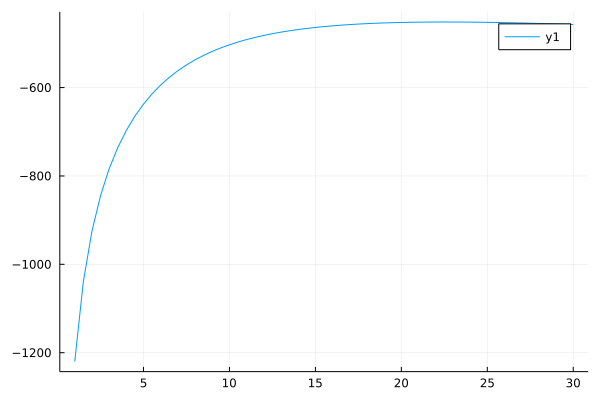

In [98]:
mcs = 1:0.5:30
lls = [logL(mc, σc, log_fpbh, posts) for mc in mcs]
plot(mcs, lls)

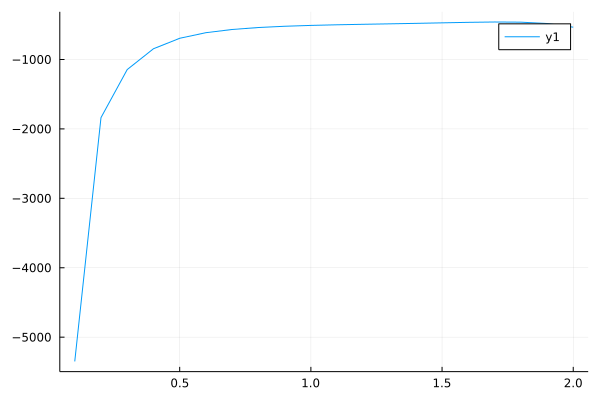

In [99]:
σcs = 0.1:0.1:2
lls = [logL(mc, σc, log_fpbh, posts) for σc in σcs]
plot(σcs, lls)

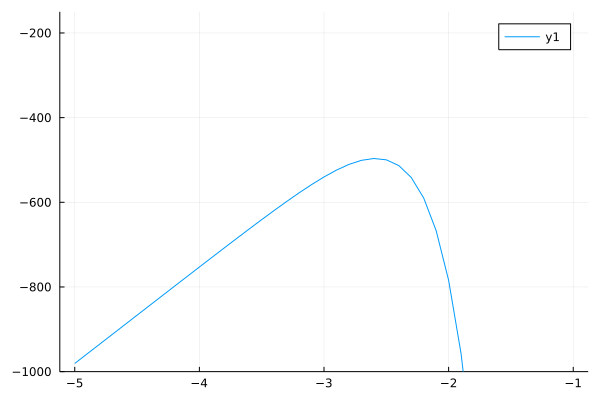

In [102]:
log_fpbhs = -5:0.1:-1
lls = [logL(mc, σc, log_fpbh, posts) for log_fpbh in log_fpbhs]
plot(log_fpbhs, lls, ylim=(-1e3, -150))

## mcmc

In [103]:
likelihood = ps -> LogDVal(logL(ps.mc, ps.σc, ps.log_fpbh, posts))

prior = BAT.NamedTupleDist(
    mc=(1) .. (30),
    σc=(0.1) .. (2.0),
    log_fpbh=(-4) .. (-0.0)
)

posterior = PosteriorDensity(likelihood, prior);

In [104]:
true_par_values = (mc=mc, σc=σc, log_fpbh=-3)
likelihood(true_par_values)

LogDVal{Float64}(-540.1200667471676)

In [105]:
@time begin
    println("Start sampling.")

    burnin = MCMCMultiCycleBurnin(max_ncycles=1000)
    samples, chains = bat_sample(posterior, MCMCSampling(mcalg=MetropolisHastings(), nsteps=10^4, nchains=4, burnin=burnin))

    println(" ")
    println("Finish sampling.")
end

save("backup/samples_$model.jld2", Dict("samples" => samples, "chains" => chains))

Start sampling.
 
Finish sampling.
2130.297386 seconds (52.42 G allocations: 1.901 TiB, 19.75% gc time, 0.09% compilation time)


┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/algotypes/bat_default.jl:44
┌ Info: Using transform algorithm PriorSubstitution()
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/chain_pool_init.jl:56
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/chain_pool_init.jl:173
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/multi_cycle_burnin.jl:35
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 1 tuned, 4 converged.
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC Tuning cycle 3 fi

In [107]:
samples = load("backup/samples_$model.jld2")["samples"];

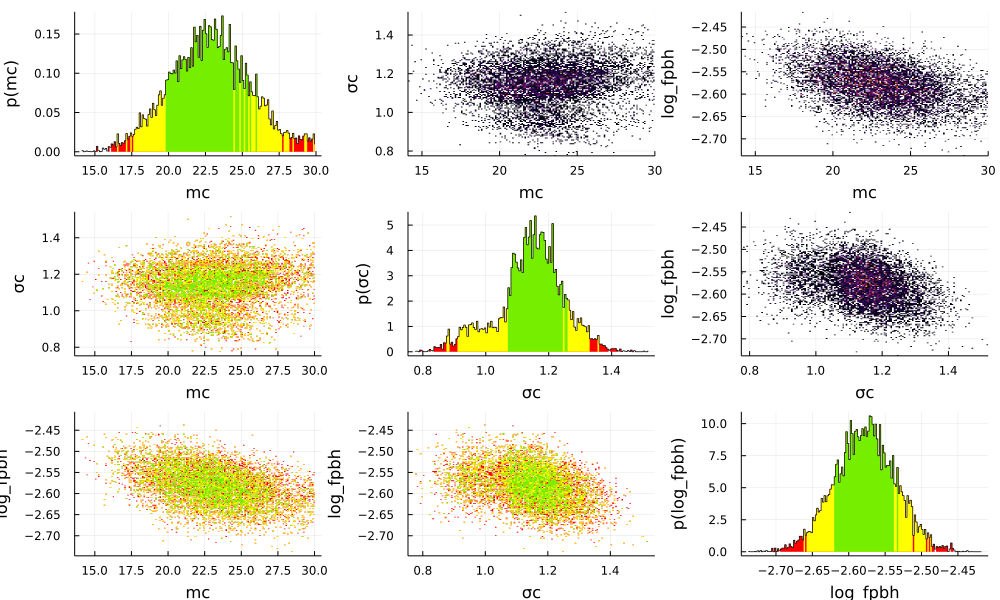

In [17]:
plot(samples)

In [19]:
# plot(
#     samples, :log_p3,
#     mean = true, std = true, globalmode = true, marginalmode = true,
#     nbins = 50, title = "Marginalized Distribution for y"
# )

In [20]:
sd = SampledDensity(posterior, samples)
display(sd)

BAT.jl - SampledDensity
──────────────────────────────

Sampling:
─────────────────────────
total number of samples:      918
effective number of samples: (mc = 201.80969763172732, σc = 146.08103984858695, log_fpbh = 189.90892499799085)


Parameter estimates:
─────────────────────────
number of free parameters: 3

NamedTuple{(:parameter, :mean, :std, :global_mode, :marginal_mode), Tuple{Symbol, Float64, Float64, Float64, Float64}}[(parameter = :mc, mean = 16.99085761567653, std = 2.2122642835181123, global_mode = 16.754656023930146, marginal_mode = 16.35), (parameter = :σc, mean = 0.8407914207087999, std = 0.0853291473539181, global_mode = 0.8008363441722768, marginal_mode = 0.8875), (parameter = :log_fpbh, mean = -2.5318046043473985, std = 0.06491226694644411, global_mode = -2.492530718392467, marginal_mode = -2.559)]


Covariance matrix:
─────────────────────────
3×3 Named Matrix{Float64}
  cov ╲  │          mc           σc     log_fpbh
─────────┼─────────────────────────────────────

In [21]:
function merger_rate1st(mc, σc, f)
    δm = m_max - m_min
    int(m1, m2) = δm^2 * mergerRateDensity1st(m_min + δm * m1, m_min + δm * m2, mc, σc, f)
    #     println("p1=$p10, p2=$p20, p3=$p30")
    function integrand(x, f)
        f[1] = int(x[1], x[2])
    end
    result, err = cuhre(integrand, rtol=1e-3)
    0.5 * result[1]
end

function merger_rate2nd(mc, σc, f)
    δm = m_max - m_min
    int(m1, m2) = δm^2 * mergerRateDensity2nd(m_min + δm * m1, m_min + δm * m2, mc, σc, f)
    #     println("p1=$p10, p2=$p20, p3=$p30")
    function integrand(x, f)
        f[1] = int(x[1], x[2])
    end
    result, err = cuhre(integrand, rtol=1e-3)
    0.5 * result[1]
end

merger_rate2nd (generic function with 1 method)

In [24]:
mc, σc, f = 16.99085761567653, 0.8407914207087999, 10^-2.5318046043473985

(16.99085761567653, 0.8407914207087999, 0.002938971642317574)

In [25]:
merger_rate1st(mc, σc, f), merger_rate2nd(mc, σc, f)

(42.94574930738684, 0.7105084448252117)

In [26]:
merger_rate2nd(mc, σc, f) / merger_rate1st(mc, σc, f)

0.016544325254164362

In [27]:
get_post(para, samples) = [a[para] for a in samples.v]

get_post (generic function with 1 method)

In [29]:
mc_posts = get_post(:mc, samples)
σc_posts = get_post(:σc, samples)
log_fpbh_posts = get_post(:log_fpbh, samples)

fpbh_posts = 10 .^ log_fpbh_posts;

In [30]:
R_posts = zeros(length(mc_posts))
Threads.@threads for i in 1:length(R_posts)
    R_posts[i] = merger_rate(mc_posts[i], σc_posts[i], fpbh_posts[i])
end

save("backup/R_posts_$model.jld2", Dict("samples" => R_posts))
R_posts = load("backup/R_posts_$model.jld2")["samples"];

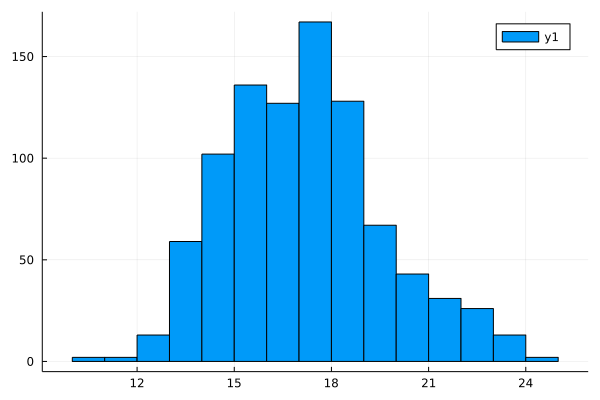

In [31]:
histogram(mc_posts)

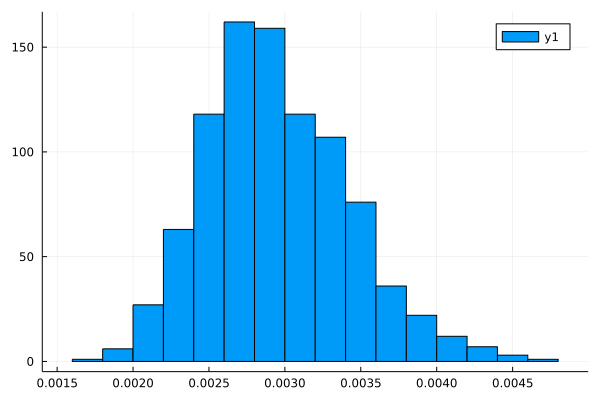

In [32]:
histogram(fpbh_posts)

In [33]:
get_quantile(posts) = quantile(posts, [0.05, 0.5, 0.95])

get_quantile (generic function with 1 method)

In [35]:
function get_σ(posts)
    x_low, x_mid, x_up = get_quantile(posts)
    x_mid, max(x_up - x_mid, x_mid - x_low)
end

get_σ (generic function with 1 method)

In [36]:
function get_interval(posts)
    x_low, x_mid, x_up = get_quantile(posts)
    x_mid, x_up - x_mid, x_mid - x_low
end

get_interval (generic function with 1 method)

In [38]:
get_interval(mc_posts)

(17.086616206471383, 4.813024672216184, 3.344126760871198)

In [39]:
get_interval(σc_posts)

(0.851820837518666, 0.12307490366184937, 0.16115626833115504)

In [40]:
get_interval(fpbh_posts)

(0.0029045248863451383, 0.0008861830484899543, 0.0006596482625421478)

In [41]:
get_interval(R_posts)

(43.16501930399336, 24.758191139434373, 17.36422329531974)

In [42]:
get_quantile(R_posts)

3-element Vector{Float64}:
 25.800796008673622
 43.16501930399336
 67.92321044342773

In [23]:
function get_fpbh_from_R(p1, p2, p3, p4, q)
    func = fpbh -> merger_rate(p1, p2, p3, p4, fpbh) - quantile(R_posts, q)
    find_zero(func, (1e-4, 1e-2))
end

get_fpbh_from_R(p1, p2, p3, p4, 0.05)

0.0038405313743226435

In [24]:
p1_qs = get_quantile(p1_posts)
p2_qs = get_quantile(p2_posts)
p3_qs = get_quantile(p3_posts)
p4_qs = get_quantile(p4_posts)
p5_qs = get_quantile(p5_posts)
fpbh_qs = get_quantile(fpbh_posts)

p1_fpbh_qs = get_quantile(p1_fpbh_posts)
p2_fpbh_qs = get_quantile(p2_fpbh_posts)
p3_fpbh_qs = get_quantile(p3_fpbh_posts)
p4_fpbh_qs = get_quantile(p4_fpbh_posts)
p5_fpbh_qs = get_quantile(p5_fpbh_posts)

3-element Vector{Float64}:
 7.937252799298751e-8
 7.861110587952049e-7
 2.9756282493003496e-6

In [25]:
ps_data = [
    [(1 + 3) / 2, get_σ(p1_fpbh_posts)...],
    [(3 + 10) / 2, get_σ(p2_fpbh_posts)...],
    [(10 + 40) / 2, get_σ(p3_fpbh_posts)...],
    [(40 + 80) / 2, get_σ(p4_fpbh_posts)...],
    [(80 + 130) / 2, get_σ(p5_fpbh_posts)...]
]

save("backup/$(model)_ps.jld2", Dict("ps" => ps_data))

In [26]:
function plot_band(low, mid, upper, left, right)
    ms = left:0.1:right
    pm_low = [low for m in ms]
    pm_mid = [mid for m in ms]
    pm_upper = [upper for m in ms]

    plot!(ms, pm_mid, label="", color="blue")
    plot!(ms, pm_low, fillrange=pm_upper, fillalpha=0.35, color="cyan", label="")
end


plot_band (generic function with 1 method)

In [27]:
# function Pm_log(σ, Mc, m)
#     1/m/σ/sqrt(2pi) * exp(- log(m/Mc)^2/2/σ^2)
# end

# best_lognormal(m) = Pm_log(0.58, 18.18, m)

# using Plots

# ms = 1:0.1:130
# ps = best_lognormal.(ms)

# plot(ms, ps, xaxis=:log, yaxis=:log, color="red", label="Log-normal", legend=:bottomleft)
# plot_band(p1_qs..., 1, 5)
# plot_band(p2_qs..., 5, 10)
# plot_band(p3_qs..., 10, 40)
# plot_band(p4_qs..., 40, 80)
# plot_band(p5_qs..., 80, 130)
# xlabel!(L"m/M_{\odot}")
# ylabel!(L"P(m)")

In [28]:
# function lognormal(σ, Mc, m)
#     1/m/σ/sqrt(2pi) * exp(- log(m/Mc)^2/2/σ^2)
# end

# best_lognormal(m) = lognormal(0.58, 18.18, m)

# using Plots

# ms = [(1+5)/2, (5+10)/2, (10+40)/2, (40+80)/2, (80+130)/2]
# ps = PmQCD.(ms, 10^(-2.26092), -0.0639596)

# plot(ms, ps, xaxis=:log, yaxis=:log, color="black", legend=:bottomleft)
# plot_band(p1_fpbh_qs..., 1, 5)
# plot_band(p2_fpbh_qs..., 5, 10)
# plot_band(p3_fpbh_qs..., 10, 40)
# plot_band(p4_fpbh_qs..., 40, 80)
# plot_band(p5_fpbh_qs..., 80, 130)
# xlabel!(L"m/M_{\odot}")
# ylabel!(L"f_\mathrm{pbh} P(m)")

In [44]:
# # using StatsPlots # no need for `using Plots` as that is reexported here
# # pyplot()
# ms = [(1+5)/2 (5+10)/2 (10+40)/2 (40+80)/2 (80+130)/2]
# ps = [p1_posts, p2_posts, p3_posts, p4_posts, p5_posts]

# violin(ms[1], ps[1], leg=false, linewidth=0, xlim=[1, 130], xaxis=:log, yaxis=:log, color="red")
# # for i in 2:5
# #     violin!(ms[i], ps[i], leg=false, linewidth=0, xlim=[1, 130], xaxis=:log, yaxis=:log, color="red", widths=1e2)
# # end
# xlabel!(L"m/M_{\odot}")
# ylabel!(L"P(m)")

In [45]:
# using StatsPlots # no need for `using Plots` as that is reexported here
# pyplot()

In [29]:
function get_err(end_points)
    left_points = end_points[1:end-1]
    right_points = end_points[2:end]
    mean_points = (left_points .+ right_points) ./ 2
    left_err = mean_points - left_points
    right_err = right_points - mean_points
    mean_points, left_err, right_err
end

get_err (generic function with 1 method)

In [117]:
bound_dir = "/home/bear/projects/working/PBHbounds/bounds"

"/home/bear/projects/working/PBHbounds/bounds"

In [158]:
function plot_bound!(bound_file, fillrange, label; skipstart=1)
    bound = readdlm("$bound_dir/$bound_file", skipstart=skipstart)
    plot!(bound[:, 1], bound[:, 2], fillrange=fillrange, alpha=0.35, label=label)
end

plot_bound! (generic function with 1 method)

In [113]:
# bound_cmb = readdlm("$bound_dir/CMB.txt", skipstart=1)
# bound_nano = readdlm("$bound_dir/NANOGrav.txt", skipstart=1)
# bound_eros = readdlm("$bound_dir/EROS.txt", skipstart=1)
# bound_eros = readdlm("$bound_dir/EROS.txt", skipstart=1)
# LIGO-SGWB.txt

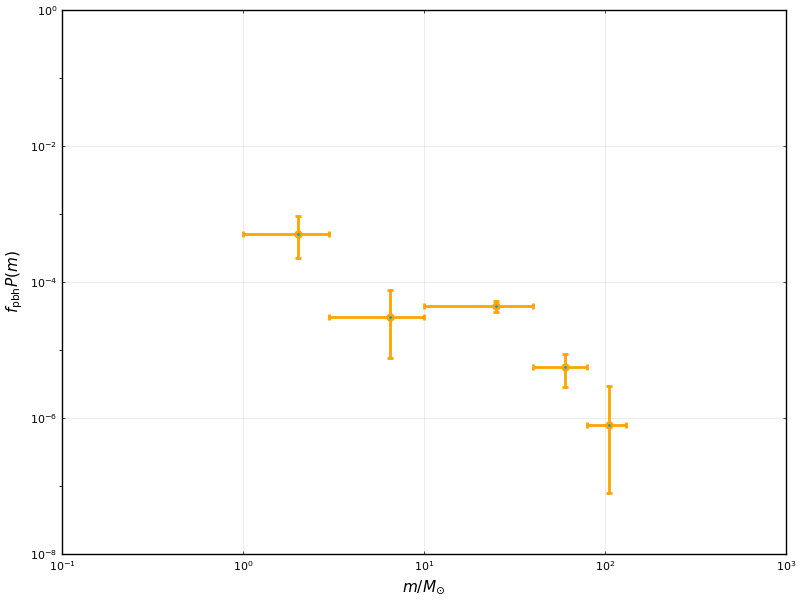

In [197]:
ps_fpbh_qs_mean = [0.0005028692744331644, 3.035034086764142e-5, 4.362318004550783e-5, 5.680971486757263e-6, 7.861110587952049e-7]
ps_fpbh_qs_low = [0.00022376430311844112, 7.654870486570416e-6, 3.591485931947084e-5, 2.808118162182561e-6, 7.937252799298751e-8]
ps_fpbh_qs_up = [0.0009292474084375293, 7.464314260080188e-5, 5.2265077004793616e-5, 8.711265381094502e-6, 2.9756282493003496e-6]
ps_fpbh_qs_left_err = ps_fpbh_qs_mean - ps_fpbh_qs_low
ps_fpbh_qs_right_err = ps_fpbh_qs_up - ps_fpbh_qs_mean;

mean_points, left_err, right_err = ([2.0, 6.5, 25.0, 60.0, 105.0], [1.0, 3.5, 15.0, 20.0, 25.0], [1.0, 3.5, 15.0, 20.0, 25.0])

plot(mean_points, ps_fpbh_qs_mean, xerr=(left_err, right_err), yerr=(ps_fpbh_qs_left_err, ps_fpbh_qs_right_err), marker=stroke(2, :orange), xscale=:log10, yscale=:log10, seriestype=:scatter, size=(800, 600), xlim=(1e-1, 1e3), ylim=(1e-8, fpbh_plot_up), label="", legend=:bottomleft, framestyle=:box)

xlabel!(L"m/M_{\odot}")
ylabel!(L"f_\mathrm{pbh} P(m)")

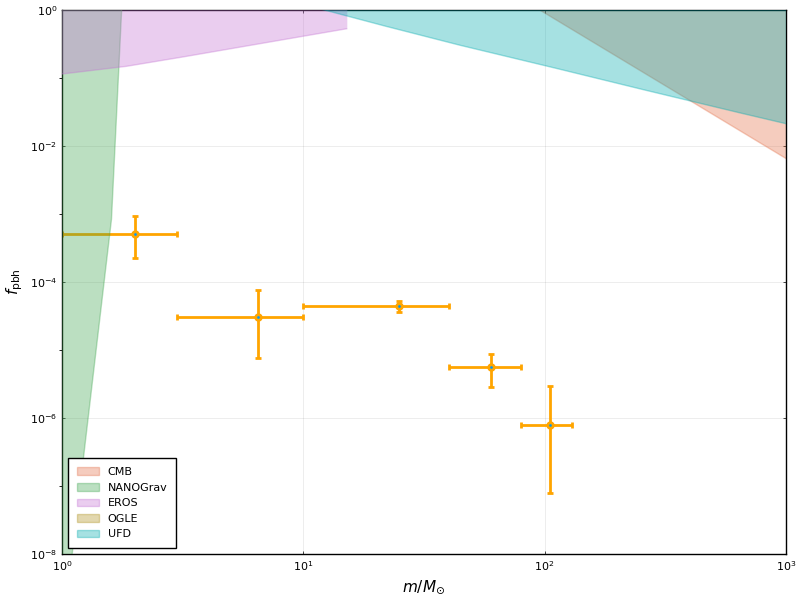

In [178]:
end_points = [1, 3, 10, 40, 80, 130]
mean_points, left_err, right_err = get_err(end_points)

ps_fpbh_posts = [p1_fpbh_posts, p2_fpbh_posts, p3_fpbh_posts, p4_fpbh_posts, p5_fpbh_posts]
ps_fpbh_qs_mean = [quantile(post, 0.5) for post in ps_fpbh_posts]
ps_fpbh_qs_low = [quantile(post, 0.05) for post in ps_fpbh_posts]
ps_fpbh_qs_up = [quantile(post, 0.95) for post in ps_fpbh_posts]
ps_fpbh_qs_left_err = ps_fpbh_qs_mean - ps_fpbh_qs_low
ps_fpbh_qs_right_err = ps_fpbh_qs_up - ps_fpbh_qs_mean;

fpbh_plot_up = 1e0
plot(mean_points, ps_fpbh_qs_mean, xerr=(left_err, right_err), yerr=(ps_fpbh_qs_left_err, ps_fpbh_qs_right_err), marker=stroke(2, :orange), xscale=:log10, yscale=:log10, seriestype=:scatter, size=(800, 600), xlim=(1e0, 1e3), ylim=(1e-8, fpbh_plot_up), label="", legend=:bottomleft, framestyle=:box)
plot_bound!("cmb.txt", fpbh_plot_up, "CMB", skipstart=0)
plot_bound!("NANOGrav.txt", fpbh_plot_up, "NANOGrav")
plot_bound!("EROS.txt", fpbh_plot_up, "EROS")
# plot_bound!("LIGO-SGWB.txt", fpbh_plot_up, "LIGO-SGWB")
# plot_bound!("LIGO.txt", fpbh_plot_up, "LIGO", skipstart=2)
plot_bound!("OGLE.txt", fpbh_plot_up, "OGLE")
# plot_bound!("Radio.txt", fpbh_plot_up, "Radio")
plot_bound!("UFdwarfs.txt", fpbh_plot_up, "UFD")
# plot_bound!("Microlensing.txt", fpbh_plot_up, "Microlensing")
# plot_bound!("M.txt", fpbh_plot_up, "M", skipstart=2)

xlabel!(L"m/M_{\odot}")
# ylabel!(L"f_\mathrm{pbh} P(m)")
ylabel!(L"f_\mathrm{pbh}")

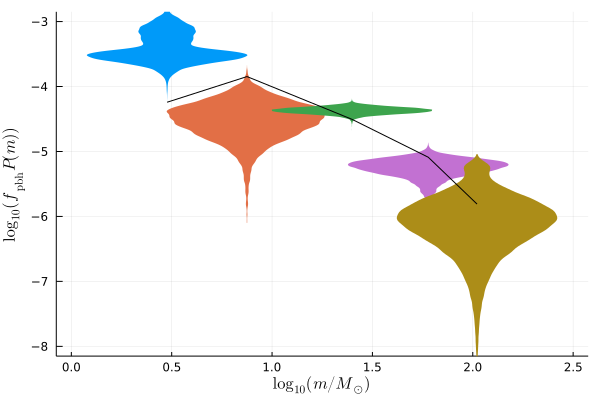

In [56]:
ms = log10.([(1 + 3) / 2 (3 + 10) / 2 (10 + 40) / 2 (40 + 80) / 2 (80 + 130) / 2])
ps = [log_p1_fpbh_posts, log_p2_fpbh_posts, log_p3_fpbh_posts, log_p4_fpbh_posts, log_p5_fpbh_posts]
ms2 = log10.([(1 + 5) / 2, (5 + 10) / 2, (10 + 40) / 2, (40 + 80) / 2, (80 + 130) / 2])
ps2 = log10.(PmQCD.(10 .^ ms2, 10^(-2.26092), -0.0639596))
violin(ms, ps, leg=false, linewidth=0, xlim=[-0, 2.5], ylim=[-8, -3], widths=[0.1, 0.1], label="")
# for i in 2:5
#     violin!(ms[i], ps[i], leg=false, linewidth=0, xlim=[1, 130], xaxis=:log, yaxis=:log, color="red", widths=1e2)
# end
plot!(ms2, ps2, color="black", legend=:bottomleft, label="")
xlabel!(L"\log_{10}(m/M_{\odot})")
ylabel!(L"\log_{10} (f_\mathrm{pbh} P(m))")

savefig("../latex/fpbh_Pm_post.pdf")
current()

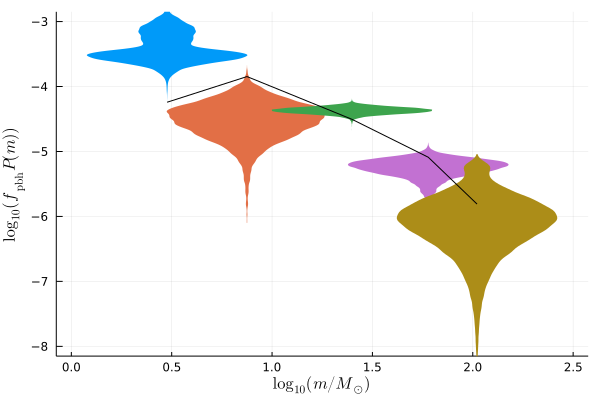

In [56]:
ms = log10.([(1 + 5) / 2 (5 + 10) / 2 (10 + 40) / 2 (40 + 80) / 2 (80 + 130) / 2])
ps = [log_p1_fpbh_posts, log_p2_fpbh_posts, log_p3_fpbh_posts, log_p4_fpbh_posts, log_p5_fpbh_posts]
ms2 = log10.([(1 + 5) / 2, (5 + 10) / 2, (10 + 40) / 2, (40 + 80) / 2, (80 + 130) / 2])
ps2 = log10.(PmQCD.(10 .^ ms2, 10^(-2.26092), -0.0639596))
violin(ms, ps, leg=false, linewidth=0, xlim=[-0, 2.5], ylim=[-8, -3], widths=[0.1, 0.1], label="")
# for i in 2:5
#     violin!(ms[i], ps[i], leg=false, linewidth=0, xlim=[1, 130], xaxis=:log, yaxis=:log, color="red", widths=1e2)
# end
plot!(ms2, ps2, color="black", legend=:bottomleft, label="")
xlabel!(L"\log_{10}(m/M_{\odot})")
ylabel!(L"\log_{10} (f_\mathrm{pbh} P(m))")

savefig("../latex/fpbh_Pm_post.pdf")
current()

In [58]:
sum([2p1_qs[2], 7p2_qs[2], 30p3_qs[2], 40p4_qs[2], 50p5_qs[2]])

0.9632837464931812

## merger rate

In [43]:
post_190521 = get_post_func("190521")
post_200115 = get_post_func("200115_042309")
post_200105 = get_post_func("200105_162426")

post_190814 = get_post_func("190814")
post_190425 = get_post_func("190425")
post_190426 = get_post_func("190426_152155")

LoadError: ArgumentError: Cannot open 'LIGO-data/masses_source_frame_posterior/GW200115_042309_posterior.txt': not a file

In [44]:
ms = 22:0.1:27
ms2 = 2.2:0.0005:2.6
# ps = post_190814.(ms2, 1.58)
ps = post_190814.(ms, 2.5)
# ps2 = post_200115.(5.7, ms)
# ps3 = post_200105.(5.7, ms)
plot(ms, ps)
# plot!(ms, ps3)

LoadError: UndefVarError: post_190814 not defined

In [66]:
thr = 7.708648380664132e-5;
function get_area(thr, post_data)
    post, m1_min, m1_max, m2_min, m2_max = post_data
    δm1 = m1_max - m1_min
    δm2 = m2_max - m2_min

    function post_new(m1, m2)
        p = post(m1, m2)
        p >= thr ? p : 0
    end
    int(m1, m2) = δm1 * δm2 * post_new(m1_min + δm1 * m1, m2_min + δm2 * m2)
    function integrand(x, f)
        f[1] = int(x[1], x[2])
    end
    result, err = cuhre(integrand, rtol=1e-3, minevals=1e4)
    result[1]
end

function get_thr(post_data)
    fzero(thr -> get_area(thr, post_data) - 0.9, 1e-5, 1e2)
end

function get_cond_merger_rate(p1, p2, p3, p4, fpbh, post_data, thr)
    post, m1_min, m1_max, m2_min, m2_max = post_data
    δm1 = m1_max - m1_min
    δm2 = m2_max - m2_min
    #     println(δm1)
    #     println(δm2)

    R12_new(m1, m2) = post(m1, m2) >= thr ? R12(m1, m2, p1, p2, p3, p4, fpbh) : 0
    int(m1, m2) = δm1 * δm2 * R12_new(m1_min + δm1 * m1, m2_min + δm2 * m2)
    #     println("p1=$p10, p2=$p20, p3=$p30")
    function integrand(x, f)
        f[1] = int(x[1], x[2])
    end
    result, err = cuhre(integrand, rtol=1e-1)
    result[1]
end

# function get_cond_merger_rate2(p1, p2, p3, p4, fpbh, post_data, thr)
#     post, m1_min, m1_max, m2_min, m2_max = post_data
#     δm1 = m1_max - m1_min
#     δm2 = m2_max - m2_min
# #     println(δm1)
# #     println(δm2)

#     R12_new(m1, m2) = R12(m1, m2, p1, p2, p3, p4, fpbh)
#     int(m1, m2) = δm1 * δm2 * R12_new(m1_min + δm1*m1, m2_min + δm2*m2)
# #     println("p1=$p10, p2=$p20, p3=$p30")
#     function integrand(x, f)
#         f[1] = int(x[1], x[2])
#     end
#     result, err = cuhre(integrand, rtol=1e-1)
#     result[1]
# end

get_cond_merger_rate (generic function with 1 method)

In [67]:
# post_data = [post_200105, 6, 12, 1.5, 2.5];
post_data = [post_190814, 20, 30, 1, 3];
thr = get_thr(post_data)
println(thr)
println(get_area(thr, post_data))

i = 10
@time get_cond_merger_rate(p1_posts[i], p2_posts[i], p3_posts[i], p4_posts[i], fpbh_posts[i], post_data, thr)

0.9739968563422006
0.8999991232723439
  0.120874 seconds (191.72 k allocations: 11.237 MiB, 98.79% compilation time)


0.08769483365799279

In [68]:
get_cond_merger_rate(p1_qs[2], p2_qs[2], p3_qs[2], p4_qs[2], fpbh_qs[2], post_data, thr)

0.158249172122616

In [69]:
function get_R_post(post_data)
    len = length(p1_posts)
    result = zeros(len)
    thr = get_thr(post_data)
    println(thr)
    Threads.@threads for i in 1:len
        #     for i in 1:len
        result[i] = get_cond_merger_rate(p1_posts[i], p2_posts[i], p3_posts[i], p4_posts[i], fpbh_posts[i], post_data, thr)
        #         println(result[i])
    end
    result
end

get_R_post (generic function with 1 method)

In [76]:
@time R_post_190521 = get_R_post([post_190521, 10, 130, 10, 130]);
save("backup/$(model)_R_post_190521.jld2", Dict("posts" => R_post_190521))

R_post = load("backup/$(model)_R_post_190521.jld2")["posts"];
get_interval(R_post)

7.640945329601645e-5
 99.070596 seconds (1.84 G allocations: 82.175 GiB, 37.76% gc time)


(0.1348361527596281, 0.1517239946901525, 0.085135502107985)

In [71]:
@time R_post_200105 = get_R_post([post_200105, 1, 20, 1, 5]);
save("backup/$(model)_R_post_200105.jld2", Dict("posts" => R_post_200105))

R_post = load("backup/$(model)_R_post_200105.jld2")["posts"];
get_interval(R_post)

0.11904931449897149
140.596177 seconds (2.75 G allocations: 122.894 GiB, 40.54% gc time)


(1.3154973933882095, 1.8580113620780867, 0.8111780079698246)

In [77]:
@time R_post_200115 = get_R_post([post_200115, 1, 15, 1, 5]);
save("backup/$(model)_R_post_200115.jld2", Dict("posts" => R_post_200115))

R_post = load("backup/$(model)_R_post_200115.jld2")["posts"];
get_interval(R_post)

0.23815995169003396
100.700494 seconds (1.90 G allocations: 84.871 GiB, 40.80% gc time)


(0.6061524810517771, 1.2792894115280962, 0.4793522462786629)

In [78]:
@time R_post_190814 = get_R_post([post_190814, 20, 30, 1, 3]);
save("backup/$(model)_R_post_190814.jld2", Dict("posts" => R_post_190814))

R_post = load("backup/$(model)_R_post_190814.jld2")["posts"];
get_interval(R_post)

0.9739968563422006
113.756288 seconds (2.18 G allocations: 97.438 GiB, 40.68% gc time)


(0.15480595062365143, 0.12956171278411116, 0.08337347265485746)

In [79]:
@time R_post_190425 = get_R_post([post_190425, 1, 3, 1, 3]);
save("backup/$(model)_R_post_190425.jld2", Dict("posts" => R_post_190425))

R_post = load("backup/$(model)_R_post_190425.jld2")["posts"];
get_interval(R_post)

1.4869594970023843
155.764865 seconds (2.97 G allocations: 132.938 GiB, 41.70% gc time)


(4.498936328202388, 10.34309535029306, 3.5907467516955416)

In [80]:
@time R_post_190426 = get_R_post([post_190426, 1, 10, 1, 5]);
save("backup/$(model)_R_post_190426.jld2", Dict("posts" => R_post_190426))

R_post = load("backup/$(model)_R_post_190426.jld2")["posts"];
get_interval(R_post)

0.01945568718629488
110.785597 seconds (1.85 G allocations: 82.786 GiB, 38.79% gc time)


(23.821579236575523, 49.11425414682524, 18.265984628435504)

In [119]:
function merger_rate(p1, p2, p3, p4, fpbh, m1_min=m_min, m1_max=m_max, m2_min=m_min, m2_max=m_max)
    δm1 = m1_max - m1_min
    δm2 = m2_max - m2_min
    int(m1, m2) = δm1 * δm2 * R12(m1_min + δm1 * m1, m2_min + δm2 * m2, p1, p2, p3, p4, fpbh)
    function integrand(x, f)
        f[1] = int(x[1], x[2])
    end
    result, err = cuhre(integrand, rtol=1e-3)
    0.5 * result[1]
end

merger_rate (generic function with 5 methods)

In [136]:
function β_func(p1, p2, p3, p4, fpbh, post, m1_min=m_min, m1_max=m_max, m2_min=m_min, m2_max=m_max)
    δm1 = m1_max - m1_min
    δm2 = m2_max - m2_min
    thr = fzero(thr -> get_area(post, thr, m1_max, m2_max) - 0.9, 1e-8, 1e2)
    println(thr)

    R12_new(m1, m2) = post(m1, m2) >= thr ? R12(m1, m2, p1, p2, p3, p4, fpbh) * VT(m1, m2) : 0
    int(m1, m2,) = δm1 * δm2 * R12_new(m_min + δm1 * m1, m_min + δm2 * m2)
    function integrand(x, f)
        f[1] = int(x[1], x[2])
    end
    result, err = cuhre(integrand, rtol=1e-1)
    0.5 * result[1]
end

β_func (generic function with 6 methods)

In [137]:
β_func(p1_qs[2], p2_qs[2], p3_qs[2], p4_qs[2], fpbh_qs[2], post_190521, 50, 130, 1, 130)

7.630986699178444e-5


0.6071002662613768

## SGWB

In [1]:
p1, p2, p3, p4, fpbh = 0.17802770765919407, 0.010630979074396193, 0.015322323607851678, 0.001978567639202855, 0.002849789033321095

(0.17802770765919407, 0.010630979074396193, 0.015322323607851678, 0.001978567639202855, 0.002849789033321095)

In [24]:
# freqs = 10 .^ (-4:0.1:log10(νs(3, 30, 30)))
# des = dE_over_dν.(freqs, 30, 30, z0) 
# plot(freqs, des, xaxis=:log, yaxis=:log)

In [25]:
R12(m1, m2, p1, p2, p3, p4, fpbh)

0.021487596376369877

In [26]:
@btime tz(z0)

  11.213 ms (400144 allocations: 18.32 MiB)


4.3512192063734195e17

In [10]:
# @btime tz_inter(z0)

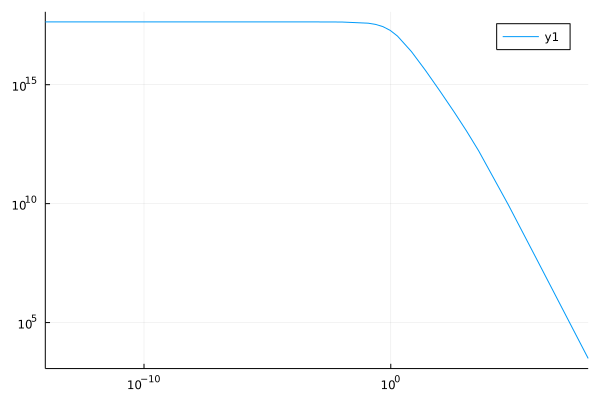

In [27]:
plot(tz, xaxis=:log, yaxis=:log, xlim=(1e-14, 1e8))

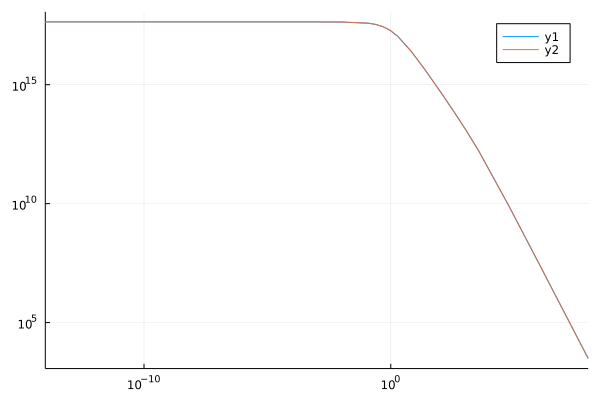

In [28]:
plot(tz_inter, xaxis=:log, yaxis=:log, xlim=(1e-14, 1e8))
plot!(tz, xaxis=:log, yaxis=:log, xlim=(1e-14, 1e8))

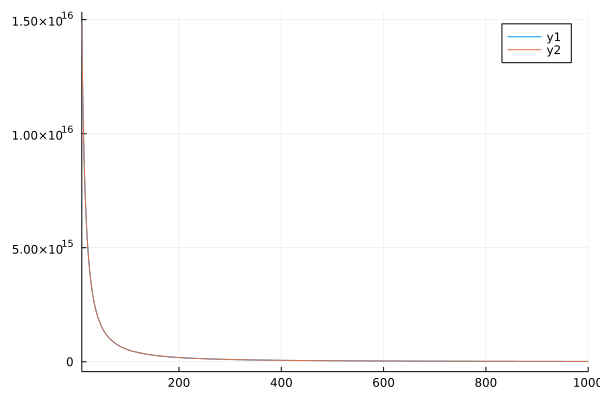

In [29]:
plot(tz_inter, xlim=(1e1, 1e3))
plot!(tz, xlim=(1e1, 1e3))

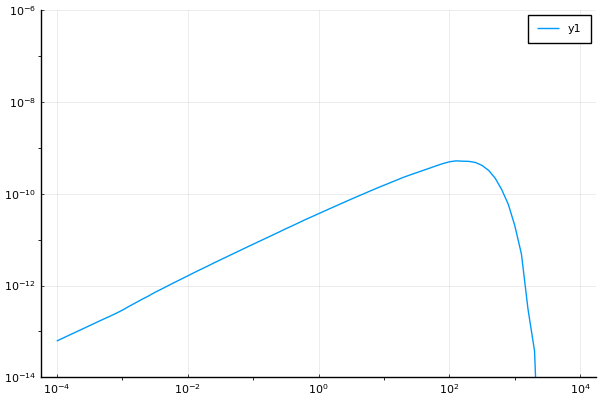

In [21]:
Mc, σ, fpbh, ν, m1, m2 = 14.79986248130652, 0.6499999896908367, 1e-3, 1e-3, 20, 20

Ωgw_int_log(σ, Mc, fpbh, ν, m1, m2, z0)

@time Ωgw2_log(σ, Mc, fpbh, ν, m1, m2)

@time Ωgw_log2(σ, Mc, fpbh, ν)

freqs = 10 .^ (-4:0.1:4)
len = length(freqs)
result = zeros(len)
Threads.@threads for i in 1:len
    tmp = Ωgw_log(σ, Mc, fpbh, freqs[i])
    result[i] = tmp > 0 ? tmp : 1e-30
end

pyplot()
plot(freqs, result, xaxis=:log, yaxis=:log, ylim=(1e-14, 1e-6))

In [58]:
# function Ωgw2(p1, p2, p3, p4, fpbh, ν, m1, m2)
    
#     int(z) = let δz = (νs(3, m1, m2)/ν - 1 - z0) # min((νs(3, m1, m2)/ν - 1 - z0), 30)
#         δz * Ωgw_int(p1, p2, p3, p4, fpbh, ν, m1, m2, z0 + δz * z)
#     end
    
# #     int(m1, m2, z) = δm^2 * (νs(3, m1, m2)/ν - 1 - z0) * Ωgw_int(p1, p2, p3, p4, fpbh, ν, m_min + δm * m1, m_min + δm * m2, z0 + (νs(3, m1, m2)/ν - 1 - z0) * z)
    
# #     println(int(0.5))
#     function integrand(x, f)
#         f[1] = int(x[1])
#     end
#     result, err = cuhre(integrand, rtol=1e-2)
#     result[1]
# end

In [41]:
# fpbh_low = get_fpbh_from_R(p1, p2, p3, p4, 0.05)
# fpbh_mid = get_fpbh_from_R(p1, p2, p3, p4, 0.5)
# fpbh_up = get_fpbh_from_R(p1, p2, p3, p4, 0.95)
fpbh_low, fpbh_mid, fpbh_up = get_quantile(fpbh_posts)

3-element Vector{Float64}:
 0.002183533350567462
 0.002849789033321095
 0.003760809718765114

In [42]:
@time Ωgw(p1, p2, p3, p4, fpbh, 1e-4)

  0.257123 seconds (949.97 k allocations: 59.558 MiB, 93.31% compilation time)


7.604400004482313e-13

In [21]:
# fs_ogw = 10 .^ (-4.5:0.05:4)
# len = length(fs_ogw)
# ogws_mid = zeros(len)
# Threads.@threads for i in 1:len
#     ogws_mid[i] = Ωgw(p1, p2, p3, p4, fpbh_mid, fs_ogw[i])
# end

In [44]:
# ogws_low = zeros(len)
# Threads.@threads for i in 1:len
#     ogws_low[i] = Ωgw(p1, p2, p3, p4, fpbh_low, fs_ogw[i])
# end

# ogws_up = zeros(len)
# Threads.@threads for i in 1:len
#     ogws_up[i] = Ωgw(p1, p2, p3, p4, fpbh_up, fs_ogw[i])
# end

In [1]:
model = "GWTC2_5bin_low_spin_heavy_mass"

using GWSC, JLD2, DelimitedFiles, Plots, LaTeXStrings
const time_O3a = 149.9 #;(* days *)
# include("population.jl")

149.9

In [2]:
# save("backup/$(model)_ogws.jld2", Dict("fs_ogw" => fs_ogw, "ogws_low" => ogws_low, "ogws_mid" => ogws_mid, "ogws_up" => ogws_up))
fs_ogw = load("backup/$(model)_ogws.jld2", "fs_ogw")
ogws_low = load("backup/$(model)_ogws.jld2", "ogws_low")
ogws_mid = load("backup/$(model)_ogws.jld2", "ogws_mid")
ogws_up = load("backup/$(model)_ogws.jld2", "ogws_up");

In [261]:
TObs = 205.4 / 365.25;
ρThSGWB = 3.0

ligo_o3 = LIGO(name="LIGO_O3", TObs=TObs, ρThSGWB=ρThSGWB);
fs_ligo_o3, ΩPIResult_ligo_o3, _ = ΩPI(ligo_o3);

ligo_design = LIGO(name="LIGO_Design", ρThSGWB=3, TObs=0.5);
fs_ligo_design, ΩPIResult_ligo_design, _ = ΩPI(ligo_design);

lisa = LISA(ρThSGWB=ρThSGWB);
fs_lisa, ΩPIResult_lisa, _ = ΩPI(lisa);

taiji = TAIJI(ρThSGWB=ρThSGWB);
fs_taiji, ΩPIResult_taiji, _ = ΩPI(taiji);

tianqin = TIANQIN(ρThSGWB=ρThSGWB);
fs_tianqin, ΩPIResult_tianqin, _ = ΩPI(tianqin);

ce = LIGO(name="CE", ρThSGWB=ρThSGWB);
fs_ce, ΩPIResult_ce, _ = ΩPI(ce);

et = LIGO(name="ET", ρThSGWB=ρThSGWB);
fs_et, ΩPIResult_et, _ = ΩPI(et);

bbo = BBO(ρThSGWB=ρThSGWB, TObs=1.0);
fs_bbo, ΩPIResult_bbo, _ = ΩPI(bbo);

decigo = DECIGO(ρThSGWB=ρThSGWB, TObs=1.0);
fs_decigo, ΩPIResult_decigo, _ = ΩPI(decigo);

PI_NEMO = readdlm("backup/PI_NEMO.txt");

nano12_ogw_pi_freqs = readdlm("/home/bear/projects/working/pta/11yr_stochastic_analysis/nano12_ogw_pi_freqs.txt")

nano12_ogw_pi = readdlm("/home/bear/projects/working/pta/11yr_stochastic_analysis/nano12_ogw_pi.txt");

TObs = 30.0;

ipta = PTA(NP=36, σRMS=1e2, TObs=TObs, ρThSGWB=ρThSGWB);
fsipta, ΩPIsipta = ΩPI(ipta);

fast = PTA(NP=50, σRMS=5e1, TObs=TObs, ρThSGWB=ρThSGWB);
fsfast, ΩPIsfast = ΩPI(fast);

ska = PTA(NP=100, σRMS=2e1, TObs=TObs, ρThSGWB=ρThSGWB);
fsska, ΩPIsska = ΩPI(ska);

In [262]:
using Cuba
using SpecialFunctions
heaviside(t) = 0.5 * (sign(t) + 1.0)

k0 = 3.6e6

function ktof(k)
    m = 1.4e13 / k^2.0
    f = 2.8760950429212986e-9 / sqrt(m)
end

function Pϕ(A, α, k)
    kmin = 0.091 * k0
    kmax = 1.0 * k0
    #     if α != 0
    #         A = A*α/(-1+(kmax/kmin)^α)
    #     else
    #         A = A/log(kmax/kmin)
    #     end
    return A * 1.0 * heaviside(kmax - k) * heaviside(k - kmin) * (k / kmin)^α
end

function Ist(t, s)
    log1 = log(abs((-2.0 + t * (2.0 + t)) / (3.0 - s^2)))
    temp1 = 1.0 + t - s
    temp2 = 1.0 + t + s
    temp3 = -5.0 + s^2 + t * (2.0 + t)
    temp4 = 288.0 * temp3^2.0 / temp1^6.0 / temp2^6.0
    temp4 * (
        π^2 / 4.0 * temp3^2 * heaviside(t - sqrt(3.0) + 1)
        +
        (-temp1 * temp2 + 0.5 * temp3 * log1)^2.0
    )
end

function ΩGW0(k, t, s, A, α)
    temp1 = 1.0 + t - s
    temp2 = 1.0 + t + s
    temp3 = t * (2 + t) * (s^2 - 1) / temp1 / temp2
    u = temp2 / 2
    v = temp1 / 2
    Pu = Pϕ(A, α, u * k)
    Pv = Pϕ(A, α, v * k)
    1.0 / 12.0 * temp3^2 * Ist(t, s) * Pu * Pv
end

ΩGW0(0.9 * k0, 0.1, 0, 0.1, 0.1)

function ΩGWk(k, A, α)
    smin = -1
    smax = 1
    tmin = 0
    tmax = 2 * k0 / k
    ΩGWk00(k, t, s, A, α) = (smax - smin) * (tmax - tmin) * ΩGW0(k, tmin + (tmax - tmin) * t, smin + (smax - smin) * s, A, α)
    function integrand(x, f)
        f[1] = ΩGWk00(k, x[2], x[1], A, α)
    end
    result, err = cuhre(integrand, rtol=1e-3, maxevals=Int(1e9))
    result[1] * 9.0e-5
end

@time ΩGWk(k0, 0.1, 0.1)

testks = 10 .^ range(-4, 1, length=100);
testks = testks * k0;
@time ΩGW1s = ΩGWk.(testks, 0.0046979981159710965, -0.11161746880132495);

  0.162735 seconds (1.45 M allocations: 35.319 MiB, 80.05% compilation time)
  3.033586 seconds (92.59 M allocations: 1.673 GiB, 9.87% gc time, 0.74% compilation time)


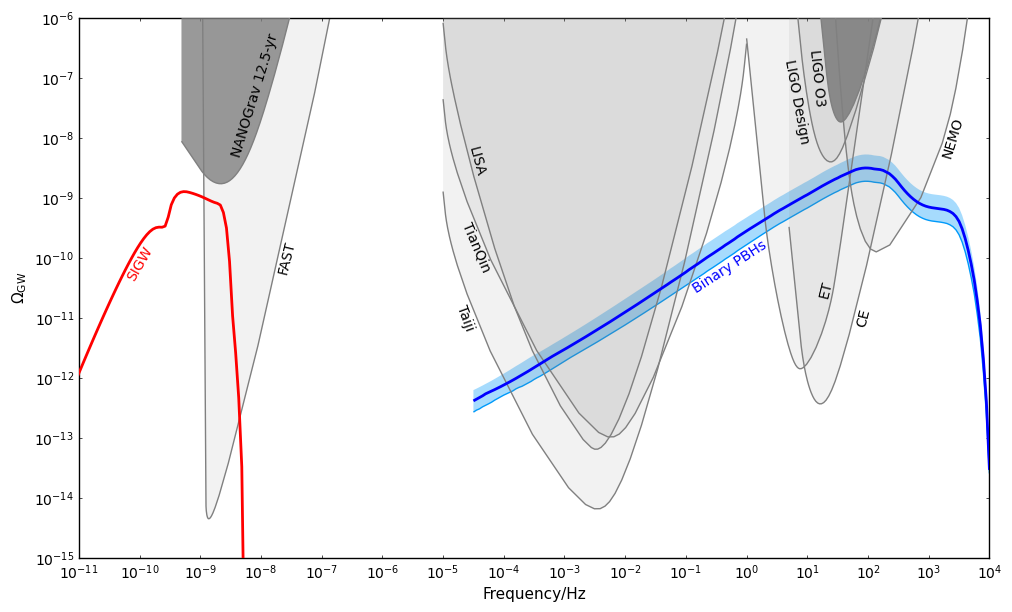

In [263]:
pyplot()
text_size = 10
color = :gray
fillalpha = 0.1

plot(fsfast, ΩPIsfast, c=color, fillrange=1e-6, fillalpha=fillalpha)
plot!(fs_ogw, ogws_low, fillrange=ogws_up, fillalpha=0.35, c=1, label="")


plot!(PI_NEMO[:, 1], PI_NEMO[:, 2], c=color, fillrange=1e-6, fillalpha=fillalpha)
plot!(nano12_ogw_pi_freqs, nano12_ogw_pi, fillrange=1e-6, color=color, fillalpha=0.8)
plot!(fs_ligo_design, ΩPIResult_ligo_design, label="LIGO-Design", c=color, fillrange=1e-6, fillalpha=fillalpha)
plot!(fs_lisa, ΩPIResult_lisa, label="LISA", c=color, fillrange=1e-6, fillalpha=fillalpha)
# plot!(fs_bbo, ΩPIResult_bbo, label="BBO", c=:black)
# plot!(fs_decigo, ΩPIResult_decigo, label="TAIJI", c=:black)
plot!(fs_taiji, ΩPIResult_taiji, label="TAIJI", c=color, fillrange=1e-6, fillalpha=fillalpha)
plot!(fs_tianqin, ΩPIResult_tianqin, label="TIANQIN", c=color, fillrange=1e-6, fillalpha=fillalpha)
plot!(fs_ce, ΩPIResult_ce, label="CE", c=color, fillrange=1e-6, fillalpha=fillalpha)
plot!(fs_et, ΩPIResult_et, label="ET", c=color, fillrange=1e-6, fillalpha=fillalpha)
plot!(fs_ligo_o3, ΩPIResult_ligo_o3, fillrange=1e-6, label="LIGO-O3a: snr=2", color=color, fillalpha=0.9)
plot!(fs_ogw, ogws_mid, xaxis=:log, yaxis=:log, xlim=(1e-11, 1e4), ylim=(1e-15, 1e-6), label=L"\Omega_{\mathrm{GW}}", framestyle=:box, color=:blue, minorticks=true, legend=nothing, size=(1000, 600), lw=2, grid=false, gridalpha=0.1, xticks=10 .^ (-11:4.0), yticks=10 .^ (-15:-6.0), tickfontsize=10)
plot!(ktof.(testks), ΩGW1s, c=:red, lw=2)
# plot!(fs_bbo, bbo.Ωn.(fs_bbo))
xlabel!("Frequency/Hz")
ylabel!(L"\Omega_{\mathrm{GW}}")
annotate!([(8e-9, 5e-8, text("NANOGrav 12.5-yr", text_size, rotation=73)),
        (1e-10, 8e-11, text("SIGW", text_size, :red, rotation=60)),
        (2.7e-8, 1e-10, text("FAST", text_size, rotation=76)),
        (1.45e1, 1e-7, text("LIGO O3", text_size, rotation=276)),
        (6.7e0, 4e-8, text("LIGO Design", text_size, rotation=280.5)),
        (2e1, 3e-11, text("ET", text_size, rotation=76)),
        (8.5e1, 1e-11, text("CE", text_size, rotation=76)),
        (2.5e3, 1e-8, text("NEMO", text_size, rotation=73)),
        (3.6e-5, 4e-9, text("LISA", text_size, rotation=285)),
        (2.3e-5, 1e-11, text("Taiji", text_size, rotation=290)),
        (3.5e-5, 1.5e-10, text("TianQin", text_size, rotation=293)),
        (5.3e-1, 0.7e-10, text("Binary PBHs", text_size, :blue, rotation=33))])
savefig("../latex/ogw.pdf")
# current()

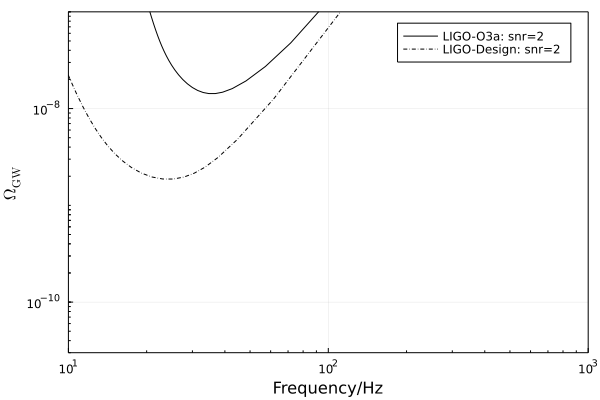

In [124]:
gr()
# plot(fs_ogw, ogws_mid, xaxis=:log, yaxis=:log, xlim=(1e-4, 1e4), ylim=(1e-14, 1e-6), label=L"\Omega_{\mathrm{GW}}", legend=:topleft, framestyle=:box, color=:blue, minorticks=true)
# plot!(fs_ogw, ogws_low, fillrange=ogws_up, fillalpha=0.35, c=1, label="")
plot(fs_ligo_o3, ΩPIResult_ligo_o3, label="LIGO-O3a: snr=2", color="black", xaxis=:log, yaxis=:log, xlim=(1e1, 1e3), ylim=(3e-11, 1e-7), minorticks=true, legend=:topright, framestyle=:box)
plot!(fs_ligo_design, ΩPIResult_ligo_design, label="LIGO-Design", ls=:dashdot, color="black")
# plot!(fs_lisa, ΩPIResult_lisa, label="LISA", ls=:solid, color="purple")
plot!(fs_ce, ΩPIResult_ce, label="CE", ls=:dash, color="black")
plot!(fs_et, ΩPIResult_et, label="ET", ls=:dot, color="black")
xlabel!("Frequency/Hz")
ylabel!(L"\Omega_{\mathrm{GW}}")
# savefig("../latex/ogw.pdf")

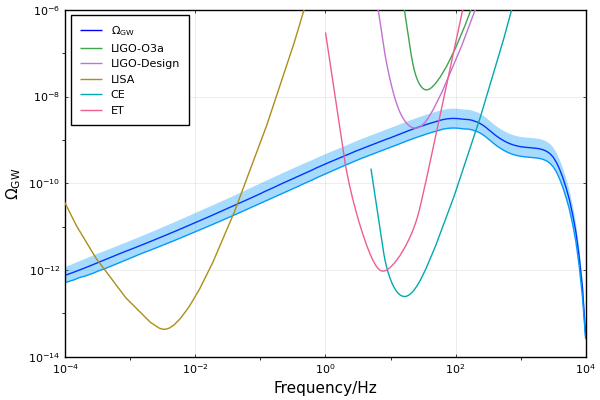

In [21]:
pyplot()
plot(fs_ogw, ogws_mid, xaxis=:log, yaxis=:log, xlim=(1e-4, 1e4), ylim=(1e-14, 1e-6), label=L"\Omega_{\mathrm{GW}}", legend=:topleft, framestyle=:box, color=:blue)
plot!(fs_ogw, ogws_low, fillrange=ogws_up, fillalpha=0.35, c=1, label="")
plot!(fs_ligo_o3, ΩPIResult_ligo_o3, label="LIGO-O3a")
plot!(fs_ligo_design, ΩPIResult_ligo_design, label="LIGO-Design")
plot!(fs_lisa, ΩPIResult_lisa, label="LISA")
plot!(fs_ce, ΩPIResult_ce, label="CE")
plot!(fs_et, ΩPIResult_et, label="ET")
xlabel!("Frequency/Hz")
ylabel!(L"\Omega_{\mathrm{GW}}")

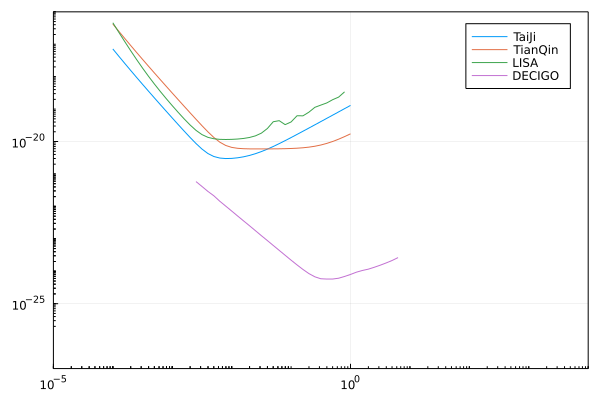

In [16]:
freqs = 10 .^ (-4:0.1:0)
freqs2 = 10 .^ (-6:0.1:2)
plot(freqs, sqrt.(taiji.Sn.(freqs)), xaxis=:log, yaxis=:log, label="TaiJi", xlim=(1e-5, 1e4), ylim=(1e-27, 1e-16), minorticks=true, legend=:topright, framestyle=:box)
plot!(freqs, sqrt.(tianqin.Sn.(freqs)), label="TianQin")
plot!(freqs, sqrt.(lisa.Sn.(freqs)), label="LISA")
plot!(freqs2, sqrt.(decigo.Sn.(freqs2)), label="DECIGO")
# plot!(bbo[:, 1], bbo[:, 2], label="BBO")

In [19]:
bbo.Ωn(1e-2)

1.692715366166507e-16

In [20]:
bbo.Sn(1e-2)

1.236910701022729e-46